# Analysis of Control Tumour Growth

This notebook aims at reproducing the tumour growth model reported in [[1](ref)]. The model is part of a larger translational PKPD study that predicted tumour stasis inducing dosing strategies for human patients from mouse data. The present study investigates the reproducibility of the reported modelling results. In particular, we try to highlight modelling assumptions and sources of uncertainty to complement the uncertainty estimation reported in [[1](ref)]. 

The structural and error model of the tumour growth model are well documented in [[1](ref)], while the population model and inference approach is less well defined. As a result, we will adopt the specified structural model and error model, and use a principled Bayesian workflow inspired by [[2](ref2)] to build a population model and inference scheme.

Bibliography:

- <a name="ref"> [1] </a> Eigenmann et. al., Combining Nonclinical Experiments with Translational PKPD Modeling to Differentiate Erlotinib and Gefitinib, Mol Cancer Ther (2016)
- <a name="ref2"> [2] </a> Betancourt, https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html (April 2020), last visited: 14/06/2020
- <a name="ref3"> [3] </a> Koch et. al., Modeling of tumor growth and anticancer effects of combination therapy, Journal of Pharmacokinetics and Pharmacokinetics, (2009)

## Overview of modelling approach

In this notebook we will follow [[1](ref)] to construct a tumour growth model of the form

\begin{equation*}
    V_T \sim \mathbb{P}(\cdot | \theta),
\end{equation*}

where $\mathbb{P}(V_T | \theta)$ is a distribution of tumour growth curves $V_T$ that may be observed in a group of patients. The distribution incorporates different apspects of the growth biology. In particular, it consists of a structural model that formalises our mechanistic understanding of the tumour growth, a population model that describes the expected variation of growth patterns between patients, and an error model that tries to capture the biology that is too complex to be formalised by the former two models. This results in a predicted distribution of growth curves $\mathbb{P}(V_T | \theta)$ parameterised by the model parameters $\theta $. The predictions of the tumour growth model $\mathbb{P}(V_T | \theta)$ substantially vary for different choices of $\theta $. The goal of this notebook is to find a set of model parameters $\theta $ that best captures the tumour growth in patients.

The most straightforward way to find a good set of $\theta $ would be to measure the tumour growth in a few patients and infer parameters $\theta $ that best describe the observations $V^{\text{obs}}_T$. One might then hope that the model will not only capture the observed data, but will also be able to predict the tumour growth in other patients. While the idea seems reasonable, in practice there are a number of limitations that make tumour growth monitoring in humans impractical. It would therefore be desireable if the tumour growth could be measured in model organisms instead, and one could somehow translate the modelling results to humans. This is the approach that was taken in [[1](ref)].

We will retrace the steps described in [[1](ref)]. In particular, we will use Bayesian inference to learn good model parameters $\theta $ that capture the behaviour of the tumour growth in an appropriate model organism, and then try to translate the model to predict human tumour growth. 

The principled Bayesian inference approach inspired by [[2](ref2)] requires us to formulate our prior expectations for reasonable model parameters $\theta $ in terms of prior probability distributions 

\begin{equation*}
    \theta \sim \mathbb{P}(\cdot | \lambda )
\end{equation*}

where $\lambda $ are some hyperparameters of the prior distributions which we may be used to tune the priors to better reflect our expectations. In other words, prior to the inference we explicitly state how likely we think certain values of the parameters $\theta $ are, either based on experience or intuition. For our purposes these priors are mainly used to point the model to the right order of magnitude of certain parameters. For example, the initial tumour volume is more likely to be of the order of $1\, \text{cm}^3$ than $1\, \text{km}^3$. The combination of the priors and the tumour growth model lead to a prior predictive model

\begin{equation*}
    V_T \sim \mathbb{P}(\cdot | \lambda ) = \int \text{d}\theta \, \mathbb{P}(\cdot | \theta)\mathbb{P}(\theta | \lambda),
\end{equation*}

which formalises our expectation for feasible growth curves before learning better $\theta $ from the observations $V^{\text{obs}}_T$. Bayesian inference provides a framework how to improve from our prior expectations of feasible $\theta $ values to a distribution of $\theta $ that are more likely to describe the data well

\begin{equation*}
     \mathbb{P}(\theta | \lambda ) \quad \stackrel{\text{inference}}{\longrightarrow}\quad \mathbb{P}(\theta | V^{\text{obs}}_T ).
\end{equation*}

The in that way derived posterior probability distribution of $\theta$ allows the construction of a posterior predictive model of probable tumour growth patterns

\begin{equation*}
    V_T \sim \mathbb{P}(\cdot | V^{\text{obs}}_T ) = \int \text{d}\theta \, \mathbb{P}(\cdot | \theta)\mathbb{P}(\theta | V^{\text{obs}}_T).
\end{equation*}

This distribution will be the result of the inference. It is the best model we will be able to come up with to describe the tumour growth in the model organism. In a final step, we will try to translate the derived model to humans.

## 1. Available data

In [[1](ref)], the tumour growth inhibition (TGI) PKPD model of Erlotinib and Gefitinib was derived from two separate *in vivo* experiments. In particular, patient-derived tumour explants LXF A677 (adenocarcinoma of the lung) and cell line-derived tumour xenografts VXF A431 (vulva cancer) were subcutaneously implanted in mice. Each experiment comprised a control group and six groups treated with either Erlotinib or Gefitnib at one of three dose levels each. Treatments were orally administered once a day.

The inverstigation of the full TGI-PKPD model is not subject of this notebook, but may be found in other notebooks of this repository (reference appear once they exist). Here, we focus on establishing a good understanding of the untreated tumour growth. In particular, this will allow us to critically assess the modelling choices in [[1](ref)], and explore alternatives. It further allows to derive posteriors for the growth parameters, that may inform the choice of priors for the full TGI-PKPD model inference.

We will now import the data sets. According to [[2](ref)], we are not supposed to look at the data prior to building the PKPD model and especially not inform our choice of prior distributions by the data. We would otherwise be in danger of artificially tuning the priors such that the prior predictive model describes the data more closely. However, the prior distributions are rather supposed to reflect our expectations for feasible ranges of model parameters without being biased by the data. Tuning the prior predictive model by hand is particularly problematic for non-linear models, such as PKPD models, which may have mutliple sets of reasonable parameters (multi-modal). By tuning the parameter priors by hand we will likely only be able to find one such set. Choosing priors that concentrate too much on such a locally optimal parameter set may exclude the globally optimal parameter set and hinder the inference. We will therefore retract from visualising the data and just check that the import of the data was successful by looking at the data in tabular form.

In [1]:
#
# Import raw LXF A677 data.
#
import os
import pandas as pd

# Import LXF A677 data
path = os.getcwd()  # to make import independent of local path structure
lxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_LXF.csv')

# Display data
print('Raw LXF A677 Control Growth Data Set:')
lxf_data_raw

Raw LXF A677 Control Growth Data Set:


,#ID,TIME,DOSE,ADDL,II,Y,YTYPE,CENS,CELL LINE,DOSE GROUP,DRUG,DRUGCAT,EXPERIMENT,BW,YTV,KA,V,KE,w0
0,40,0,.,.,.,191.808,2,.,1,0,2,0,2,26.8,.,55,1.11,3.98,191.8080
1,94,0,.,.,.,77.2475,2,.,1,0,2,0,2,18.3,.,55,1.11,3.98,77.2475
2,95,0,.,.,.,186.2,2,.,1,0,2,0,2,22.3,.,55,1.11,3.98,186.2000
3,40,3,0,.,.,.,.,.,1,0,2,0,2,26.1,.,55,1.11,3.98,191.8080
4,40,4,0,2,1,.,.,.,1,0,2,0,2,26.5,.,55,1.11,3.98,191.8080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,140,2,.,.,.,126.852,2,.,1,0,2,0,2,23.6,126.852,55,1.11,3.98,79.3305
154,94,4,.,.,.,125.316,2,.,1,0,2,0,2,18.5,125.316,55,1.11,3.98,77.2475
155,170,4,.,.,.,109.33,2,.,1,0,2,0,2,27.9,109.33,55,1.11,3.98,80.0565
156,170,2,.,.,.,94.221,2,.,1,0,2,0,2,27.7,94.221,55,1.11,3.98,80.0565


In [2]:
#
# Import raw VXF A341 data.
#
import os
import pandas as pd

# Import VXF A341 data
path = os.getcwd()  # to make import independent of local path structure
vxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_VXF.csv', sep=';')

# Display data
print('Raw VXF A341 Control Growth data set:')
vxf_data_raw

Raw VXF A341 Control Growth data set:


,#ID,MICE,TIME,DOSE,ADDL,II,TUMOR,YTV,w0
0,1,708,0,.,.,.,92.5,.,92.5
1,1,708,3,.,.,.,115.2,115.2,92.5
2,1,708,3,0,3,1,.,.,92.5
3,1,708,7,.,.,.,133.2,134.2,92.5
4,1,708,7,0,2,1,.,.,92.5
...,...,...,...,...,...,...,...,...,...
128,7,743,30,.,.,.,1304.6875,1304.6875,207.4
129,7,743,32,.,.,.,1419.6,1419.6,207.4
130,7,743,35,.,.,.,1530.9,1530.9,207.4
131,7,743,37,.,.,.,1576.4625,1576.4625,207.4


### Cleaning the data

Note how the first data set seems to contain a lot more information than the second one. However, there is a lot of information that is not relevant for us. These data sets were manipulated with Monolix. That is why the meaning of most column keys can be looked up in the Monolix documentation. However, there are some customised keys whose meaning is not immediately clear. 

All we really need for our analyis is

- **#ID** indicating which mouse was measured,
- **TIME** indicating the time point of each measurement,
- **TUMOUR VOLUME** indicating the measured tumour volume.

While the columns **#ID** and **TIME** are easy to idenitfy in the data sets, **TUMOUR VOLUME** was intentionally chosen to be outside of the existing column keys. In both data sets there exist two keys that may potentially encode for the measured tumour volumes: **Y** and **YTV** in LXF; and **TUMOR** and **YTV** in VXF. The true measurements of the first experiment are easily identified by looking into the Monolix documentation. **Y** is here generally used as an identifier for the observations. For the second table it seems less obvious which column might contain the true data. However, in analogy with the first data set one might suspect that **YTV** is not the actual data. So until this will be clarified at a later stage, we will choose to use **TUMOR** as the true data.

Remarks on remaining column keys:

- **DOSE**: Seems to be a customised key encoding for the applied dose. This is the control group so we should ensure that this column has only NaN or zero entries.
- **ADDL**, **II**: According to Monolix these keys encode for the number of doses (ADDL) to add in addition to the dose in intervals specified by II. Since this is supposed to be the control group, we should filter out any rows with non-null values for these keys.
- **YTYPE**, **CENS**: According to Monolix these keys encode for the data type (tumour volume in this case) and whether the measurered values were subject to censoring. We should make sure that censored data should be dealt with accordingly and only one data type is present in the data set.
- **CELL LINE**, **DOSE GROUP**, **DRUG**, **EXPERIMENT**: These customised keys are quite self-explanatory. We should make sure that the data we use is uni-valued in these columns.
- **DRUGCAT**: The meaning of this key is less clear. It may refer to the drug category encoding for the route of administration. We should make sure that this column is also only uni-valued. If mutliple values are assumed we need to clarify what this column means.
- **BW**: refers to the body weight of the mouse at the time of the measurement.
- **KA**, **V**, **KE**, **w0**: These keys are customised keys, whose meaning is not immediately clear. They appear to be parameters of the PKPD model. We are interested in infering parameters, so we are not interested in any previously obtained parameters, and choose to ignore this column.

Remarks on units of relevant columns:

The raw data sets do not contain the units of the measured quantities. From the reference [[1](ref)], we may however infer that 
- **TIME**: was measured in $\text{day}$, and
- **TUMOUR VOLUME**: was measured in $\text{mm}^3$. 

In [3]:
#
# Create LXF A677 data from raw data set.
#
import os
import pandas as pd

# Import LXF A677 data
path = os.getcwd()  # to make import independent of local path structure
lxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_LXF.csv')

# Make sure that data is stored as numeric data
lxf_data = lxf_data_raw.apply(pd.to_numeric, errors='coerce')

# Mask data for non-null Y rows
lxf_data = lxf_data[lxf_data['Y'].notnull()]

# Rename Y to TUMOUR VOLUME in mm^3
lxf_data = lxf_data.rename(columns={'Y': 'TUMOUR VOLUME in mm^3'})

# Rename TIME to TIME in day
lxf_data = lxf_data.rename(columns={'TIME': 'TIME in day'})

# Raise error if DOSE, ADDL, II, YTYPE, CENS, CELL LINE, DOSE GROUP, DRUG, EXPERIMENT or DRUGCAT are not uni-valued
if len(lxf_data['DOSE'].unique()) > 1:
    raise ValueError
if len(lxf_data['ADDL'].unique()) > 1:
    raise ValueError
if len(lxf_data['II'].unique()) > 1:
    raise ValueError
if len(lxf_data['YTYPE'].unique()) > 1:
    raise ValueError
if len(lxf_data['CENS'].unique()) > 1:
    raise ValueError
if len(lxf_data['CELL LINE'].unique()) > 1:
    raise ValueError
if len(lxf_data['DOSE GROUP'].unique()) > 1:
    raise ValueError
if len(lxf_data['DRUG'].unique()) > 1:
    raise ValueError
if len(lxf_data['EXPERIMENT'].unique()) > 1:
    raise ValueError
if len(lxf_data['DRUGCAT'].unique()) > 1:
    raise ValueError

# Keep only #ID, TIME and TUMOUR VOLUME column
lxf_data = lxf_data[['#ID', 'TIME in day', 'TUMOUR VOLUME in mm^3']]

# Delete raw data from memory
del lxf_data_raw

# Display cleaned data set
print('LXF A677 Control Growth:')
lxf_data

LXF A677 Control Growth:


,#ID,TIME in day,TUMOUR VOLUME in mm^3
0,40,0,191.8080
1,94,0,77.2475
2,95,0,186.2000
59,136,0,118.5885
60,140,0,79.3305
...,...,...,...
153,140,2,126.8520
154,94,4,125.3160
155,170,4,109.3300
156,170,2,94.2210


In [4]:
#
# Create VXF A341 data from raw data set.
#
import os
import pandas as pd

# Import LXF A677 data
path = os.getcwd()  # to make import independent of local path structure
vxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_VXF.csv', sep=';')

# Make sure that data is stored as numeric data
vxf_data = vxf_data_raw.apply(pd.to_numeric, errors='coerce')

# Mask data for rows where TUMOR and YTV coincide
vxf_data = vxf_data[vxf_data['TUMOR'].notnull()]

# Rename TUMOR to TUMOUR VOLUME in mm^3
vxf_data = vxf_data.rename(columns={'TUMOR': 'TUMOUR VOLUME in mm^3'})

# Rename TIME to TIME in day
vxf_data = vxf_data.rename(columns={'TIME': 'TIME in day'})

# Raise error if DOSE, ADDL or II are not uni-valued
if len(vxf_data['DOSE'].unique()) > 1:
    raise ValueError
if len(vxf_data['ADDL'].unique()) > 1:
    raise ValueError
if len(vxf_data['II'].unique()) > 1:
    raise ValueError

# Keep only #ID, TIME and TUMOUR VOLUME column
vxf_data = vxf_data[['#ID', 'TIME in day', 'TUMOUR VOLUME in mm^3']]

# Delete raw data from memory
del vxf_data_raw

# Display cleaned data set
print('VXF A341 Control Growth:')
vxf_data

VXF A341 Control Growth:


,#ID,TIME in day,TUMOUR VOLUME in mm^3
0,1,0,92.5000
1,1,3,115.2000
3,1,7,133.2000
5,1,10,136.8000
7,1,14,233.2800
...,...,...,...
128,7,30,1304.6875
129,7,32,1419.6000
130,7,35,1530.9000
131,7,37,1576.4625


## 2. Tumour Growth Model Structure

The tumour growth model presented in [[1](ref)] consists of a structural model, a population model and an error model. The combination of these models leads to a distribution of tumour growth curves 

\begin{equation*}
    V_T \sim \mathbb{P}(\cdot | \theta ),
\end{equation*}

parameterised by some model parameters $\theta $. We will refer to $\mathbb{P}(V_T | \theta ) $ as the tumour growth model structure, as it defines how a set of model parameters $\theta $ translate into observable growth patterns. Once we have defined the model structure, the challenge will be to find good parameters $\theta $ that not only capture the observations, but also generalise well to future measurements, such that the model may be used to predict growth curves of patients.


### Structural model 

The structural model in [[1](ref)] is an ordinary differential equation for the tumour volume

\begin{equation*}
\frac{\text{d}V^s_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V^s_T}{2\lambda _0 V^s_T + \lambda _1} - \kappa CV^s_T,
\end{equation*}

where
- $V^s_T$ is the tumour volume predicted by the structural model in $[\text{mm}^3]$, 
- $\lambda_0$ is the exponential growth rate of the tumour in $[1/\text{day}]$, 
- $\lambda_1$ is the linear growth rate of the tumour in $[\text{mm}^3/\text{day}]$,
- $\kappa $ is the potency of the drug in $[\text{L}/\text{mg}/\text{day}]$, and
- $C$ is the drug concentration in the plasma in $[\text{mg}/\text{L}]$.

The superscript of the volume variable $V^s_T$ indicates that the tumour volume was predicted by the structural model. The distinction between the true tumour volume predictions $V_T$ and the predictions of the structural model $V^s_T$ will become clear later in the text. In absence of the drug $C\equiv 0$, the structural model reduces to
 
\begin{equation*}
\frac{\text{d}V^s_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V^s_T}{2\lambda _0 V^s_T + \lambda _1}.
\end{equation*}

This is the structural model we will use to model the tumour growth in the xenograft mice. 

This model makes a number of assumptions and approximations to describe the tumour growth. The most obvious assumption of the model is a transition of the tumour growth from an exponential growth to a linear growth at a characteristic tumour volume

\begin{equation*}
V^c_T = \frac{\lambda_1}{2\lambda _0}.
\end{equation*}

For $V^s_T<<V^c_T$ the tumour is modelled by an exponential growth, while for $V^s_T>>V^c_T$ the tumour growth is linear. This tumour growth model was first introduced in [[3](ref3)], and builds on the intuition that in the early stages of the tumour an abundance of oxygen and nutrients leads to a constant doubling time of cancerous cells, and therefore to an exponential growth. However, in later stages of the tumour growth oxygen and other sources of nutrition are being depleted inside the tumour, and only the 'shell' tumour cells are able to proliferate at the inital rate. While there are ways for the tumour mass to expand in the inside too, by changing the mode of metabolism to glycolysis or rewiring of the blood vessels to improve the oxygen supply, it is clear that the total growth rate of the tumour should be expected to slow down. Due to the complexity of the process it is not obvious that the growth should be expected to change qualitatively from exponential to linear. However, in [[3](ref3)] it was argued that a linear growth phase was observed for later stages of tumour evolution in experiments. By investigating the estimate for $V^c_T$ we will be able to assess this modelling choice directly. (Note: It may be worth investigating whether modelling of a characteristic length scale, from which tumour volume and surface can be derived, may better reflect the intuition for the two growth phases. This would make the assumptions about the geoemtry of the tumour more explicit.)

### Validity of structural model

It is intuitively clear that the validity of the model cannot hold for all values of $V^s_T\in \mathbb{R}_{\geq 0}$ and $t\in\mathbb{R}_{\geq 0}$. For small tumour sizes, where the tumour may only consist of a small number of cancerous cells, it is no longer appropriate to assume a deterministic growth of the tumour. A stochastic model incorporating drift, and in particular a finite probablity of extinction may be more appropriate. In addition, assuming a constant growth rate of the tumour can only be justified if the mean growth behaviour of the cancerous cells does not substantially change over the simulated time period. This assumption will almost surely break down in the infancy of the tumour where mutations are essential for the selective advantage of the cancerous cells. It may therefore be expected that the proliferation rate of the cancer cells is not constant for small tumour volumes. Both these arguments suggest that the above model should have a lower limit, where the model loses validity. It is not clear what this limit should be exactly, but we may set it somewhat conservatively to $1 \, \text{mm}^3$. This tumour volume may approximately translate to a cell count of $10^7$ cells for which the deterministic approximation is well justified (assuming average cell volume of $100\, \mu\text{m}^3$, i.e. length, height and width of a cell between $1\mu\text{m}$ to $10\, \mu\text{m}$).

Similarly, with an average volume of a mouse of the order of $1\, \text{dm}^3$, it may be expected that the growth behaviour of the tumour will significantly change no later than for values of about $10^6\text{mm}^3$. We shall therefore limit the applicability of our model to the regime 

\begin{equation*}
V^s_T\in [10^{-3}, 10^3] \, \text{cm}^3.
\end{equation*}

The above arguments also suggest that we may want to introduce an upper time limit after which the modelling predictions can no longer be trusted. This time limit approximates the time point when mutations should be expected to alter the speed of the tumour growth, by either changing the metabolism, the blood vessel structure or other properties that may change the proliferation rate. It is not easy to estimate the order of this time point, but it may be approximated by an average mutation rate that can be derived from other studies. For now we will somewhat arbitrarily set the valid time interval for predictions to 

\begin{equation*}
t\in [0, 30] \, \text{day}.
\end{equation*}

This has little biological justification and is simply driven by the fact that the PKPD study contains samples over a range of 30 days. This limit may be challenged at a later stage.

As a result of the limited applicability of the model, we will deviate from the unit choice in [[1](ref)] and choose a more convenient unit scheme for the model parameters
- $V^s_T$ is the tumour volume predicted by the structural model in $[\text{cm}^3]$, 
- $\lambda_0$ is the exponential growth rate of the tumour in $[1/\text{day}]$, 
- $\lambda_1$ is the linear growth rate of the tumour in $[\text{cm}^3/\text{day}]$ and
- $\kappa $ is the potency of drug in $[\text{L}/\text{mg}/\text{day}]$.

### Population model

In [[1](ref)] the structural model parameters $\lambda_0$, $\lambda_1$, as well as the initial tumour volume $V_{T,0}$ are expected to vary between individuals. For notational ease we will define 

\begin{equation*}
\psi = (\lambda_0, \lambda_1, V_{T,0}).
\end{equation*}

The so called population model formalises the expectation for the variation of the parameters $\psi$ across individuals. In [[1](ref)], mean and variance of $\psi $ were reported, but the exact shape of the distribution was left unspecified. It is therefore possible that our population model will deviate from the one used in [[1](ref)]. The parameters $\psi $ are constrained to assume non-negative values to be biologically meaningful. We will therefore choose to model the population by a multivariate lognormal distribution, i.e. the logarithms of the parameters $\psi $ are normally distributed

\begin{equation*}
\log \psi \sim \mathcal{N}(\overline{\log \psi}, \Sigma ),
\end{equation*}

where $\overline{\log \psi} = (\overline{\log \lambda_0}, \overline{\log \lambda_1}, \overline{\log V_{T,0}})$ is the population mean of $\log \psi$, and $\Sigma = \text{diag}(\sigma ^2_{0}, \sigma ^2_{1}, \sigma ^2_{V})$ is the covariance in the population. This is a natural first choice for the population distribution, because all structural model parameters are semi-positive definite, $\psi \geq 0$. The assumption that there is no correlation between the inital tumour volume $V_{T,0}$ and the growth parameters $\lambda_0, \lambda_1$ is a strong one, especially since one might expect that a particularly large initial tumour volume may indicate an alleviated tumour growth. This assumption may be critically assessed at a later stage. 

This population model does not take possible covariates into account that may lead to a more complex populational distribution of the structural model parameters $\psi $. This is mostly due to the fact that all mice in the study were female, and the data set contains little information about any further covariates. The influence of covariates on the distribution of $\psi $ can therefore not be assesed in this study.

### Error model

Generally, the structural model predictions $V^s_T$ should not be expected to capture the observed tumour growth exactly. On the one hand the accuracy of measurements is always bound by the intrinsic uncertainty of the measurement apparatuses and other uncertainties in the measurement process, and on the other hand the structural model should rather be seen as a gross simplification of the true underlying biological processes. As such the many uncaptured subtle processes may lead to random fluctuations around the predictions $V^s_T$. In [[1](ref)] those fluctuations of the observations $V^{\text{obs}}_T$ from the structural model predictions $V^s_T$ were modelled by the residual error

\begin{equation*}
\text{Residual Error} = V_T - V^s_T = (a + b V^s_T)\varepsilon ,
\end{equation*}

where $a$ and $b$ are constants and $\varepsilon $ is a standard Gaussian random variable, $\varepsilon \sim \mathcal{N}(0, 1)$. $V_T$ emulates the behaviour of future measurements and incorporates their randomness due to measurement error and subtle processes that may not be captured by the structural model. So $V^{\text{obs}}_T$ may be interpreted as realisations of the random variable $V_T$. Intuitively the combined error model is a mixture of a constant Gaussian noise that formalises the expectation of a base level noise, and a heteroscedastic noise which assumes that the error will grow relative to the predicted volume. At this point also the error model remains an assumption that remains to be critically assessed by the end of the analysis.

It is important to note at this point that all meaningful predictions of the tumour growth model will be made by $V_T$. It is not justified to infer model parameters $\theta $ using the above described tumour growth model structure and strip away the error model for future predictions. One might be tempted to remove the undesired measurement noise in that way, which seems irrelevant for theoretical predictions of the tumour growth. However, neglecting the error model also disregards the biology that is too complex to be captured by the structural model. As long as we cannot distinguish between measurement error and biology, it is not justified to ignore the uncertainty introduced by the error model.

## 3. Prior Predictive Model

We have now fully specified the structure of the tumour growth model. The structural model 

\begin{equation*}
\frac{\text{d}V^s_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V^s_T}{2\lambda _0 V^s_T + \lambda _1}
\end{equation*}

together with the error model $\text{Residual Error} = (a + b V^s_T)\varepsilon $ allow us to construct a model

\begin{equation*}
V_T \sim \mathbb{P}(\cdot | \psi , \theta _V)
\end{equation*}

for the tumour growth in an individual with the physiological parameters $\psi = (\lambda _0, \lambda _1, V_{T,0})$ and error model parameters $\theta _V:=(a, b)$. Note that "an individual" may refer to a patient, a mouse, or any other appropriate model organism. However, because we have placed the validity of the model within the context of tumour growth in mice, we should think for now of modelling mice and not humans or other organisms.

Thus, $\mathbb{P}(V_T | \psi , \theta _V)$ predicts the tumour growth in a mouse with parameters $\psi $ and $\theta _V$. The choice of a standard Gaussian $\varepsilon $ leads to a distribution of $V_T$ that is also a Gaussian distribution centered at the structural model predictions $V^s_T=V^s_T(\psi)$ with a variance of $(a + b V^s_T)^2$, i.e. $\mathbb{P}(V_T | \psi , \theta _V) = \mathcal{N}(V^s_T, (a + b V^s_T)^2)$. This formalises the expectation that the observed tumour growth largely follows the predictions of the structural model $V^s_T$, but also allows for deviations from it due to oversimplifications of the structural model or measurement noise.

In contrast, the full tumour growth model does not focus on a specific individual, but on a group of individuals who may have varying physiological parameters $\psi $. This variation across individuals is described by the population model $\mathbb{P}(\psi | \theta _{\psi })$, where $\theta _{\psi }=(\overline{\log \psi}, \Sigma)$ is a shorthand notation for the population parameters. Different choices of $\theta _{\psi} $ describe different groups. The complete tumour growth model predicts the tumour growth patterns that may be observed in a group specified by the population parameters $\theta _{\psi}$ and error parameters $\theta _V$

\begin{equation*}
V_T \sim \mathbb{P}(\cdot | \theta ) = \int \text{d}\psi \, \mathbb{P}(\cdot | \psi , \theta _V) \mathbb{P}(\psi | \theta _{\psi}),
\end{equation*}

where we introduced the shorthand notation $\theta = (\theta _V, \theta _{\psi})$ for the model parameters. This equation is what we want to refer to as the tumour growth model structure, because it provides the framework to predict the tumour growth in individuals of a population, but is useless without an appropriate choice of model parameters $\theta $. Bayesian inference allows us to learn suitable $\theta $ for a population from a finite number of observations. We will therefore use Bayesian inference to learn such a good set of parameters $\theta $ from the available mouse data, and try to translate the learned parameters to humans.

In order to do Bayesian inference we need to formulate our expectations for good model parameters $\theta $ prior to the inference

\begin{equation*}
    \theta \sim \mathbb{P}(\cdot | \lambda),
\end{equation*}

where $\lambda $ are hyperparameters of the prior distributions to allow us to better express our expectations for the model parameters. The resulting preliminary tumour growth model, composed of the model structure and our prior expectations for feasible $\theta $, is referred to as prior predictive model in the language of Bayesian inference

\begin{equation*}
    V_T \sim \mathbb{P}(\cdot | \lambda) = \int \text{d}\theta \, \mathbb{P}(\cdot | \theta ) \mathbb{P}(\theta | \lambda) .
\end{equation*}

The choice of the prior distributions / prior predictive model has *in theory* no influence on the modelling results, provided that we have an infinite amount of data, and the prior dsitributions do not constrain the domain of support of the parameters $\theta $. In practice however, data is always limited, and in particular in the context of PKPD modelling rather sparse. The choice of priors has therefore a substantial impact on the modelling results and should be considered as an integral part of the modelling approach.

### 3.1 Importance of prior distributions for modelling results

Conceptually, one might think of Bayesian inference as improving our current understanding of the model parameters $\theta $ by learning from data. This may be illustrated by moving from a prior distribution $\mathbb{P}(\theta | \lambda )$ to a data-informed posterior distribution $\mathbb{P}(\theta | V^{\text{obs}}_T)$ of the model parameters $\theta $

\begin{equation*}
    \mathbb{P}(\theta | \lambda ) \quad \stackrel{\text{inference}}{\longrightarrow}\quad \mathbb{P}(\theta | V^{\text{obs}}_T ).
\end{equation*}

This approach has the advantage that by formulating informative prior distributions it is possible to obtain good predictive models even when only sparse data sets are available. We can thereby steer the inference into the "right" direction. It may be compared to sitting a medival history exam with only four mock exams left to prepare for it. If all our preparation has to be derived from those four mock exams, we will likely perform significantly worse than if we had previously taken a course in medival history. In this simile, our prior knowledge about medival history may illustrate the role of prior distributions in Bayesian inference. The four mock exams may resemble a sparse data set, and the outcome of the exam our posterior understanding of the model parameters. 

This simile strikes an important caveat of Bayesian inference: the modelling results will depend on our prior understanding of the model parameters. This is particularly problematic, if one has very strong expectations for feasible model parameters $\theta $ which turn out to be wrong. It is easy to imagine that in those scenarios it will take a lot of data to convince us that our prior expectations were not correct. In our simile this may be the case if we were expecting to take an economics exam instead of one about medival history. We may at first interpret the mock exam questions from an economics perspective and write about trading goods at medival times. It will probably take us way more than four mock exams to realise that the exam has actually nothing to do with economics. This shows that informative priors can not only significantly improve modelling results, but also make them a lot worse if not chosen carefully.

Note that there is a lot of controversy about appropriate prior choices, which is arguably due to the fact that for different applications of Bayesian inference the intuition and prior knowledge of model parameters varies substantially. In addition, the availability of data also ranges from very sparse to super rich data sets, such that for some applications there is no need for informative prior distributions. Irrespective of the application, a purely data-informed posterior distribution of the model parameters $\theta $ seems appealing. This could be achieved by choosing uniform prior distributions which do not favour any values for the model parameters $\theta $, which is equivalent to saying that we have no prior knowledge of the model parameters $\theta$. This would allow a general inference approach that does not rely on the expertise of the modeller. However, in
some applications it is not feasible to collect enough data to derive a predictive model without incorporating prior information into the inference scheme. For example PKPD data sets are typically sparse, and the modelling results improve substantially with an informative prior choice.

In this notebook we argue for prior choices that try to balance pros and cons of informative and non-informative prior choices. Our approach is inspired by [[2](ref2)], and leads to a prinicipled Bayesian modelling workflow which is not only transparent but may also perform well across PKPD modelling applications.

### 3.2 Prior and posterior distribution

The way our prior understanding $\mathbb{P}(\theta | \lambda )$ of the model parameters $\theta $ influences the inference of the data-informed posterior distribution $\mathbb{P}(\theta | V^{\text{obs}}_T )$  can be formally expressed by envoking Bayes' rule

\begin{equation*}
    \log \mathbb{P}(\theta | V^{\text{obs}}_T ) =  \log \mathbb{P}(V_T | \theta ) \Big| _{V_T=V^{\text{obs}}_T} + \log \mathbb{P}(\theta | \lambda ) + \text{constant},
\end{equation*}

where $\mathbb{P}(V_T | \theta ) \Big| _{V_T=V^{\text{obs}}_T}$ is the likelihood that a given set of model parameters $\theta  $ has generated the observations $V^{\text{obs}}_T$. Note that if there was no data and the likelihood term was dropped, the posterior distribution would equal the prior distribution up to a constant. This makes sense, because without data our prior understanding of the model parameters cannot be updated, and there is no reason to expect that the posterior distribution differs from the prior distribution (the constant in this case turns out to be zero). However, if we do update our understanding by learning from a particular data set with $n$ obervations $V^{\text{obs}}_T=\left\lbrace V^{(1)}_T, V^{(2)}_T, \ldots , V^{(n)}_T\right\rbrace$, the likelihood contributes to the posterior. In particular, the posterior will be a mixture of the likelihood and the prior (here the constant will be different from zero and ensure that the posterior distribution is normalised). To be more explicit, the likelihood $\mathbb{P}(V_T | \theta ) \Big| _{V_T=V^{\text{obs}}_T}$ is a shorthand notation for a product of probabilities

\begin{equation*}
    \mathbb{P}(V_T | \theta ) \Big| _{V_T=V^{\text{obs}}_T} = \prod ^n_{i=1} \mathbb{P}(V_T | \theta ) \Big| _{V_T=V^{(i)}_T}.
\end{equation*}

It is the product of the probabilities that each of the $n$ observations $V^{\text{obs}}_T=\left\lbrace V^{(1)}_T, V^{(2)}_T, \ldots , V^{(n)}_T\right\rbrace$ has been generated by the tumour growth model $\mathbb{P}(V_T | \theta )$ for a given set of model parameters $\theta $. Together with Bayes' rule

\begin{equation*}
    \log \mathbb{P}(\theta | V^{\text{obs}}_T ) =  \sum ^n_{i=1} \log \mathbb{P}(V_T | \theta ) \Big| _{V_T=V^{(i)}_T} + \log \mathbb{P}(\theta | \lambda ) + \text{constant},
\end{equation*}

this expression can be used to formalise our intuition for the relationship between the prior and posterior distribution. On the one hand, we see that the data enters the equation in a total of $n$ terms with $\mathbb{P}(V_T | \theta )\in [0,1]$, while the prior only enters once with $\mathbb{P}(\theta | \lambda ) \in [0,1]$. This captures the intuition that the relative contribution of the data to the posterior increases with the number of data points $n$. In particular, one can imagine how the initial posterior distribution gradually transforms from the prior distribution into the final posterior distribution by iteratively adding the likelihood contributions of single observations. As a result, the data can be expected to dominate the shape of the posterior as the number of data points $n$ increases, even if we had very strong prior expectations for the parameters $\theta $. In particular, for an infinite data set $n\rightarrow \infty$ the posterior distribution will be independent of the prior choice, as long as the contributions of the prior distribution are finite. 

However, if $\log \mathbb{P}(\theta | \lambda )$ is infinite for a given $\theta $, the posterior distribution will also be infinite for that $\theta $.  As a result, the posterior distribution will depend on the prior irrespective of the amount of data. An infinite value of $\log \mathbb{P}(\theta | \lambda )$ translates to a vanishing prior probability for the given $\theta $. In other words, as soon as we exclude certain parameter values prior to the inference by assigning zero probability to them, the posterior will depend on the prior choice. This illustrates that priors with a restricted domain of support will inevitably influence the modelling results. One might therefore prefer prior distributions that extend over the full domain of the parameter values. Strong belief in finite parameter regimes may then rather be expressed in terms of strongly concentrated priors, which still assign a non-vanishing probability to less likely parameter values.

### 3.3 Prior distribution selection

In the reference [[1](ref)] the prior choices for the inference were not documented. Consequently, our prior choices may differ from [[1](ref)] which would lead to different modelling results. According to the reasoning in the previous section, we will default to very wide priors for all model parameters $\theta = (\theta _V, \theta _{\psi})$, such as Cauchy distributions, and assess whether we would like to concentrate the distribution at certain parameter regimes or even exclude infeasible parameter values. Note that any other widely spread distribution with a support for all parameter values $\theta $ would be an appropriate choice to start with.

The error model parameters $\theta _V = (a, b)$ specify the expected variance of the Gaussian residual error $\varepsilon $ of the model. As a result, only non-negative values are feasible for $a$ and $b$ such that a Cauchy prior for a $a$ and $b$ is not feasible. If we still want to keep the Cauchy distribution as the base prior for $a$ and $b$, we either have to truncate the Cauchy distribution to a Half-Cauchy distribution, such that it only extends over positive values, or distribute the log-transformed $a$ and $b$ according to a Cauchy distribution. In theory both approaches are equally good with appropriate hyperparameter choices $\lambda $, see an illustration of the distributions with location 1 and scale 1 in the cell below. In practice, it is wise to always avoid hard borders in parameter space, especially when a lot of the probability mass is close to that border. This will almost always lead to numerical instabilities, which we will be able to understand when we talk about the numerical methods we use to do the inference later in the text. These hard borders can be avoided by distributing the log-transformed parameters $a$ and $b$ instead of the parameters $a$ and $b$ directly. 

Cauchy distributing the log-transformed noise parameters is generally a good idea if one has no intuition about feasible parameter regimes at all as the resulting probability density will be very heavily tailed, see figure below. However, in our case $a$ and $b$ have a clear biological meaning, and in particular the resulting error should at most be of the order of the upper limit of the model $10^3\, \text{cm}^3$. Thus a distribution that is reasonably heavy tailed, but is still able to favour values within a certain regime would be preferable. One distribution satisfying these criteria is a Gaussian distribution, see figure. We will therefore choose to distribute the log-transformed $a$ and $b$ according to Gaussian distributions

\begin{align*}
\log a \sim & \mathcal{N}(\overline{\log a}, \sigma_a) \\
\log b \sim & \mathcal{N}(\overline{\log b}, \sigma_b),
\end{align*}

where $\lambda _V = (\overline{\log a}, \sigma_a, \overline{\log b}, \sigma_b)$ are the hyperparameters of the error priors which need to be tuned to reflect our prior expectations. 

The population parameters $\overline{\log \psi} = (\overline{\log \lambda_0}, \overline{\log \lambda_1}, \overline{\log V_{T,0}})$ are semi-positive definite, which is why we chose to log-transform them earlier in the text. That means, in prinicple, any values in $\mathbb{R}$ can be assumed by the means $\overline{\log \psi }$

\begin{align*}
\overline{\log \lambda_0} \sim & \text{Cauchy}(\text{loc}_{m, 0}, \text{scale}_{m, 0}) \\
\overline{\log \lambda_1} \sim & \text{Cauchy}(\text{loc}_{m, 1}, \text{scale}_{m, 1}) \\
\overline{\log V_{T,0}} \sim & \text{Cauchy}(\text{loc}_{m,V}, \text{scale}_{m,V}).
\end{align*}

Analogous to the error model priors, the log-variances may be chosen to be Cauchy distributed with appropriate hyperparameters

\begin{align*}
\log \sigma ^2_0 \sim &\text{Cauchy}(\text{loc}_{s, 0}, \text{scale}_{s, 0}) \\
\log \sigma ^2_1 \sim & \text{Cauchy}(\text{loc}_{s, 1}, \text{scale}_{s, 1}) \\
\log \sigma ^2_V \sim & \text{Cauchy}(\text{loc}_{s, V}, \text{scale}_{s, V}).
\end{align*}

This gives us a set of priors with hyperparameters $\lambda = (\lambda _V, \lambda _{\psi})$, where $\lambda _V $ is a shorthand notation for the $\text{loc}$ and $\text{scale}$ of $a$ and $b$, and $\lambda _{\psi}$ is a shorthand notation for the $\text{loc}$ and $\text{scale}$ of the means $\overline{\log \psi}$ and variances $\Sigma $.

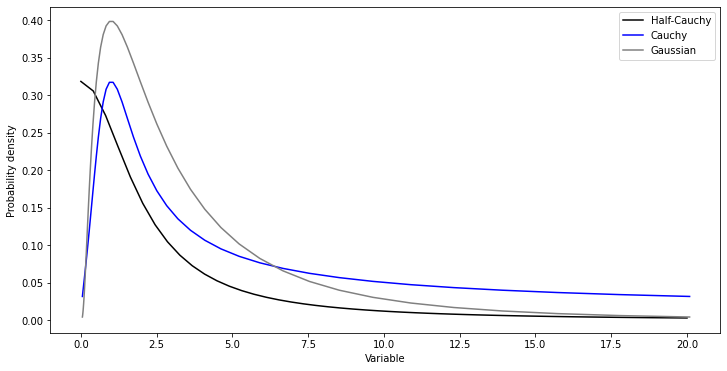

In [18]:
#
# Illustration of a variable x that is Half-Cauchy distributed with mean 0 and scale 10, and a variable y whose logarithm is Cauchy distributed with location 0 and scale 1 (location 0 in logarithm space is location 1 in linear space).
#

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import cauchy, halfcauchy, norm


# Half-Cauchy
samples_hc = np.linspace(0, 20)
probs_hc = halfcauchy.pdf(samples_hc, scale=2)

# Cauchy
log_samples = np.linspace(-3, 3)
probs_c = cauchy.pdf(log_samples, scale=1)

# Transform samples of cauchy distribution back into linear space
samples_c = np.exp(log_samples)

# Gaussian
log_samples = np.linspace(-3, 3)
probs_g = norm.pdf(log_samples, scale=1)

# Transform samples of cauchy distribution back into linear space
samples_g = np.exp(log_samples)

# Create plot of distribtuions
fig = plt.figure(figsize=(12, 6))

# Plot Half-Cauchy
plt.plot(samples_hc, probs_hc, color='black', label='Half-Cauchy')

# Plot Cauchy
plt.plot(samples_c, probs_c, color='blue', label='Cauchy')

# Plot Cauchy
plt.plot(samples_g, probs_g, color='grey', label='Gaussian')

# x and y labels
plt.xlabel('Variable')
plt.ylabel('Probability density')

# Make legend
plt.legend()

# Show plot
plt.show()

We see that all distributions are reasonably heavy tailed and only extend over positive values. The key difference is that distributing the log-transformed variables leads to a smooth drop of probability mass at the boundary. In contrast, a half-Cauchy distribution accumulates most of the mass *at* the boundary. That is why we prefer distributing the log-transformed parameters over distributing the parameters directly. We can also see that the Cauchy distribution seems to be effectively flat for larger values and therefore is not well suited to focus attention to a specific parameter regime. As a result, Gaussian distributed log-transformed variables is our choice for the variance model parameters.

### 3.4 Hyperparameter tuning

Now that we have settled for a shape of the prior distributions we need to determine their hyperparameters $\lambda $ such that our prior knowledge about the model parameters $\theta $ is reflected.

#### Error prior tuning

For both error model parameters $a$ and $b$ we have two hyperparameters to tune, the location and the scale of the log-transformed variable. Recall that $a$ is of the same scale as $V^s_T$, while $b$ determines the variance contributions proportional to the structural model predictions 

\begin{equation*}
    \text{Residual Error} = (a + b V^s_T)\epsilon .
\end{equation*}

$a$ may then be interpreted as the base level noise in $\text{cm}^3$ that may be expected from measurement error and fluctuations induced by uncaptured biological processes that do not scale with the volume size. A priori, it is difficult to develop a good intuition for the base level noise. A good strategy therefore seems to let base level range over the full domain of validity of $V_T$. This may be achieved by choosing hyperparameters such that the base level distribution has it's bulk distribution within the validity regime of the model. The bulk of the distribution is not well defined, but may in context of this notebook refer to the interior 95% probability mass of the distribution. In other words, we will choose the location and scale such that the 2.5th percentile of the base level noise distribution is $10^{-3}\, \text{cm}^3$ and the 97.5th percentile $10^{3}\, \text{cm}^3$. This may be achieved by tuning the hyperparameters of the Cauchy prior such that it's 2.5th percentile is $\log (10^{-3}/3)$ and it's 97.5th percentile is $\log (10^{3}/3)$. The factor of $3$ comes from the fact that about $99.7%$ of the probability mass of a Gaussian distribution is within $3$ standard deviations.

The relative scaling of the error $b$ is also difficult to estimate. However, we might argue that even if observations were to suggest high standard deviations realtive to the predicted value, at some point we would loose interest in the model. This is because the higher the standard deviation relative to it's predictions is, the smaller it's predictive power. We may therfore set the 97.5th percentile of the Gaussian distribution to $\log (5/3) $, indicating that any higher relative noise than 5 fold would be of little interest to us. The lower limit of feasible relative noise may be estimated by investigating how the tumour volume was measured. According to [[1](ref)] the tumour volume was estimated by measuring the largest diameter $d_L$ of the tumour on the surface of the mouse skin. In addition the extension of the tumour on the mouse skin perpendicular to this largest diameter was measured $d_S$. The tumour volume was then estimated by assuming an ellipsoid shape 

\begin{equation*}
 V_T=\frac{\pi}{6}d_1d_2d_3 \approx \frac{1}{2}d_Ld_S^2,
\end{equation*}

where it was further assumed that the unmeasured extention of the tumour would equal $d_S$, and setting $\pi \approx 3$ would suffice. So assuming that those assumptions about the geometry of the tumour were valid, the measurement error of the diameters may provide a lower bound of the relative error. Estimating the length scale measurement error with 5%, the minimum relative error may be expected to be of the order of $10^{-4}$. We may therefore set the 2.5th precentile of the $\log b$ Gaussian distribution to $\log (10^3/3)$.  

#### Population prior tuning
Valid mean values may range from $0\, \text{cm}^3/\text{day}$ to at most $1\, \text{cm}^3/\text{day}$, $0\, 1/\text{day}$ to at most $10^{3}\, \text{cm}^3/\text{day}$ and $10^{-3}\, \text{cm}^3$ to at most $1\, \text{cm}^3$. So means at center and variance of the logs such that 99th percentile is accordingly.

Scale again at zero and scale such that range from means is adobted.

### 2.1 Prior predictive checks and prior hyperparameter tuning

We have now fully specified the structure of our tumour growth PD model. If we denote the prior hyperparameters by 

\begin{equation*}
\lambda = (\lambda _V, \lambda _{\psi}) ,
\end{equation*}

where $\lambda _V = (\text{loc}_a, \text{scale}_a, \text{loc}_b, \text{scale}_b)$ and $\lambda _{\psi} = (\text{loc}_{m, 0}, \text{scale}_{m, 0}, \text{loc}_{m, 1}, \text{scale}_{m, 1}, \text{loc}_{m, V}, \text{scale}_{m, V}, \text{loc}_{s, 0}, \text{scale}_{s, 0}, \text{loc}_{s, 1}, \text{scale}_{s, 1}, \text{loc}_{s, V}, \text{scale}_{s, V})$, we can express our prior predictive model as 

\begin{equation*}
V_T \sim \mathbb{P}(\cdot | \lambda ) = \int \text{d}\psi \, \text{d}\theta _V \,  \text{d}\theta _{\psi} \, \mathbb{P}(\cdot | \psi , \theta _V) \mathbb{P}(\psi | \theta _{\psi}) \mathbb{P}(\theta _V |\lambda _V)\mathbb{P}(\theta _{\psi} |\lambda _{\psi}),
\end{equation*}

where
- $\mathbb{P}(\cdot | \psi , \theta _V)$ is the distribution of $V_T$ for a fixed set of structural model parameters $\psi $ and error model parameters $\theta _V$. The exact form of the distribution is given by the structural model and the error model.  
- $\mathbb{P}(\psi | \theta _{\psi})$ is the distribution of the structural model parameters across individuals and given by the population model.
- $\mathbb{P}(\theta _V |\lambda _V)$ and $\mathbb{P}(\theta _{\psi} |\lambda _{\psi})$ are the prior distributions of the error model parameters and the population model parameters for a given set of prior hyperparameters $\lambda $.

### Why do we need prior predictive checks?

The prior predictive model quantifies our expectations for feasible outcomes of the tumour growth PD model.  It is composed of the structural model that quantifies our understanding of the mechanisms of the tumour growth, the error model that describes how this understanding may be expected to be insufficient to capture the observations, the population model that models the growth variation that may be expected across indiviudals, and our prior belief in feasible parame. These models combined form the tumour growth PD model, and are parameterised by a set of parameters $\theta $. The values of  $\theta $ that best describe the observations are unknown. However, we can express our belief in likely $\theta $ prior to the inference by formulating prior probability distributions. By looking at all possible $\theta $ according to these priors, we can obtain a prior predictive model $\mathbb{P}(V_T|\lambda) $ that manifests our understanding of the all possible tumour growth scenarios before learning from the data.

The goal of the inference is to learn better distributions for the model parameters $\theta $ from the data, such that the model more closely resembles the observations and may be used to predict behaviour of the population. So in some sense the inference can be interpreted as moving from the prior distributions of $\theta $ without knowledge about the observed phenomena, to an improved *posterior* distribution that has learned from the data

\begin{equation*}
    \mathbb{P}(\theta _V |\lambda _V)\mathbb{P}(\theta _{\psi} |\lambda _{\psi}) \quad \stackrel{\text{inference}}{\longrightarrow}\quad  \mathbb{P}(\theta_V , \theta _{\psi} | V^{\text{obs}}_T ).
\end{equation*}

The posterior predictive model of the tumour growth can the be constructed from the prior predictive model by simply replacing the priors by the posterior distribution of $\theta$ 

\begin{equation*}
V_T \sim \mathbb{P}(\cdot | V^{\text{obs}}_T ) = \int \text{d}\psi \, \text{d}\theta _V \,  \text{d}\theta _{\psi} \, \mathbb{P}(\cdot | \psi , \theta _V) \mathbb{P}(\psi | \theta _{\psi}) \mathbb{P}(\theta_V , \theta _{\psi} | V^{\text{obs}}_T ).
\end{equation*}

Note that only the distribution of the model parameters $\theta $ has changed from the prior predictive model to the posterior predictive model.

What is left to do before we can start with the inference is to find a meaningful set of prior hyperparameters which lead to a reasonable distribution of prior predicted tumour growth curves. In particular, we need to check that the priors are not too restrictive, such that the model is able to explore all values in the expected domain of validity. Unless we have a very good reason for the priors to be more informative, this is a safe approach.

#### Error prior tuning

A priori there is little reason that any particular mean deviation size from the structural model is more likely than others. However, we have reason to believe that the structural model captures the tumour growth reasonably well, we may therefore choose the location of the Half-Cauchy distributions to be zero 

\begin{equation*}
    \text{loc}_a=0, \quad \text{loc}_b=0,
\end{equation*}

and choose their scale such that the 99th precentile occupies the upper limit of acceptable error relative to the model predictions. The baseline error dominates for low tumour volumes may therefore be set such that the 99th precentile is $10 \, \text{cm}^3$. The upper limit of a relative error may rather be 3-fold the predicted value, we may there set the scale such that the 99th percentile is 3. Note that especially a large baseline error may lead to weird tumour predictions when $V_T$ is small, i.e. $V_T<0$. So, we should keep in mind that any predictions below $10^{-3}\, \text{cm}^3$ are invalid.

#### Population prior tuning
Valid mean values may range from $0\, \text{cm}^3/\text{day}$ to at most $1\, \text{cm}^3/\text{day}$, $0\, 1/\text{day}$ to at most $10^{3}\, \text{cm}^3/\text{day}$ and $10^{-3}\, \text{cm}^3$ to at most $1\, \text{cm}^3$. So means at center and variance of the logs such that 99th percentile is accordingly.

Scale again at zero and scale such that range from means is adobted.

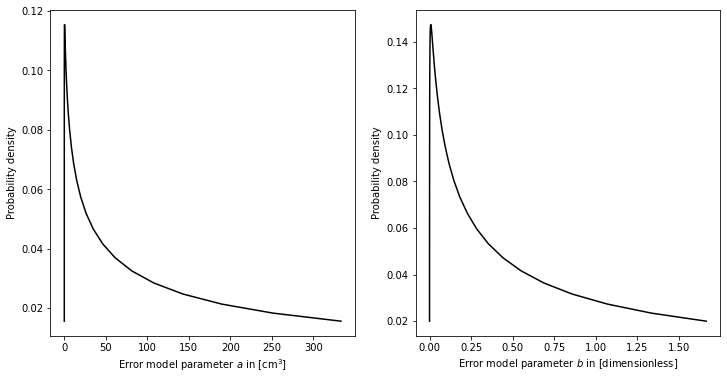

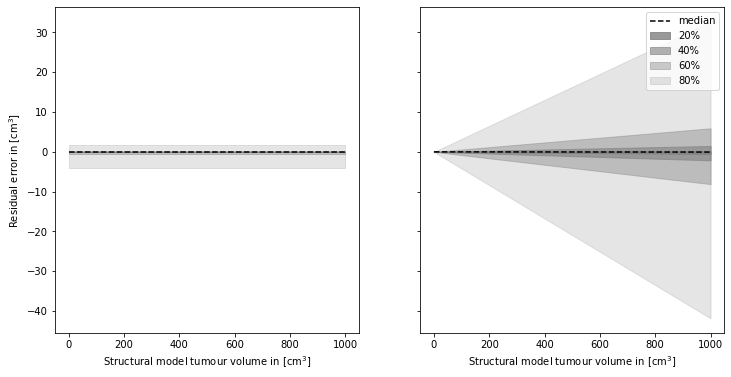

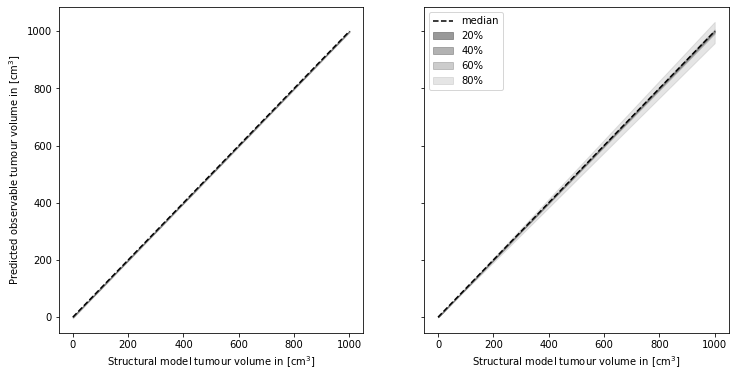

In [29]:
#
# Hyperparameter tuning of Gaussian prior for log(a) and log(b).
#
# Mean and standard deviation of the log(a) distribution are chosen such that the 2.5th percentile of the distribution is log(10^-3/3), and the 97.5th percentile is log(10^3/3), translating to a bulk prior distribution of base level noise ranging from 10^-3 cm^3 to 10^3 cm^3. 
#
# Mean and standard deviation of the log(b) distribution are chosen such that the 2.5th percentile of the distribution is log(10^-3/3), and the 97.5th percentile is log(10^3/3), translating to a bulk prior distribution of base level noise ranging from 10^-3 cm^3 to 10^3 cm^3. 
#
# The distribution is then visualised in two standard ways: I. By an approximate a * epsilon versus V_T plot (epsilon is the standard Gaussian random variable defined above), and II. By an approximate V_T + a * epsilon versus V_T plot.
#

import matplotlib.pyplot as plt
import numpy as np
import pints
from scipy.stats import norm

from pkpd.utils import find_gaussian_hyperparams


# Define 2.5th and 97.5th percentile for log(a)
left_a = -3 * np.log(10) - np.log(3)
right_a = 3 * np.log(10) - np.log(3)

# Find hyperparameters for Gaussian prior for a
mean_a, std_a = find_gaussian_hyperparams(left=left_a, right=right_a)

# Define 2.5th and 97.5th percentile for log(b)
left_b = -4 * np.log(10) - np.log(3)
right_b = np.log(5) - np.log(3)

# Find hyperparameters for Gaussian prior for a
mean_b, std_b = find_gaussian_hyperparams(left=left_b, right=right_b)

# Illustrate prior for a
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Sample PDF for a
log_samples = np.linspace(left_a, right_a)
probs = norm.pdf(log_samples, loc=mean_a, scale=std_a)

# Transform log-samples back into linear space
samples = np.exp(log_samples)

# Plot PDF of prior for a
axes[0].plot(samples, probs, color='black')

# x and y label
axes[0].set_xlabel(r'Error model parameter $a$ in [cm$^3$]')
axes[0].set_ylabel(r'Probability density')

# Sample PDF for a
log_samples = np.linspace(left_b, right_b)
probs = norm.pdf(log_samples, loc=mean_b, scale=std_b)

# Transform log-samples back into linear space
samples = np.exp(log_samples)

# Plot PDF of prior for a
plt.plot(samples, probs, color='black')

# x and y label
axes[1].set_xlabel(r'Error model parameter $b$ in [dimensionless]')
axes[1].set_ylabel(r'Probability density')

# Show plot
plt.show()

# Illustrate base line error distribution and relative error distribution
# Create V_T values
tumour_volume = np.linspace(start=10**(-3), stop=10**3)

# Instantiate Gaussian prior for a
gauss_a = pints.GaussianLogPrior(mean=mean_a, sd=std_a)

# Instantiate standard Gaussian distribution
standard_gauss = pints.GaussianLogPrior(mean=0, sd=1)

# Sample log(a) from Gaussian distribution
samples = gauss_a.sample(n=1000)

# Transform samples to linear space, i.e. a samples
samples = np.exp(samples)

# Sample from baseline error distribution by scaling the Gaussian distribution with (a * epsilon)
samples_a = samples * np.array(standard_gauss.sample(n=1000))

# Instantiate Gaussian prior for b
gauss_b = pints.GaussianLogPrior(mean=mean_b, sd=std_b)

# Instantiate standard Gaussian distribution
standard_gauss = pints.GaussianLogPrior(mean=0, sd=1)

# Sample log(a) from Gaussian distribution
samples = gauss_b.sample(n=1000)

# Transform samples to linear space, i.e. a samples
samples = np.exp(samples)

# Sample from relative error distribution by scaling the Gaussian distribution with (b * tumour_volume * epsilon)
# Tumour volume is multiplied later for convenience
samples_b = samples * np.array(standard_gauss.sample(n=1000)) 

# Create figure I: Residual error versus structural model predcitions
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Plot median
# Compute median of a
median_a = np.median(samples_a)
median_a = np.full(shape=tumour_volume.shape, fill_value=median_a)

# Compute median of b
median_b = np.median(samples_b)
median_b = tumour_volume * median_b

# Plot median
axes[0].plot(tumour_volume, median_a, color='black', linestyle='dashed', label='median')
axes[1].plot(tumour_volume, median_b, color='black', linestyle='dashed', label='median')

# Plot 40 to 60 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 40)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 60)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.8,
    label='20%')

# Compute percentiles for b
p_left = np.percentile(samples_b, 40)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 60)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.8,
    label='20%')

# Plot 30 to 70 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 30)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 70)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.6,
    label='40%')

# Plot 30 to 70 precentile
# Compute percentiles for b
p_left = np.percentile(samples_b, 30)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 70)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.6,
    label='40%')

# Plot 20 to 80 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 20)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 80)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.4,
    label='60%')

# Compute percentiles for b
p_left = np.percentile(samples_b, 20)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 80)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.4,
    label='60%')

# Plot 10 to 90 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 10)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 90)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.2,
    label='80%')

# Compute percentiles for b
p_left = np.percentile(samples_b, 10)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 90)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=p_left,
    y2=p_right,
    color='gray',
    alpha=0.2,
    label='80%')

# x and y axis label
axes[0].set_xlabel(r'Structural model tumour volume in [cm$^3$]')
axes[0].set_ylabel(r'Residual error in [cm$^3$]')

axes[1].set_xlabel(r'Structural model tumour volume in [cm$^3$]')

# Create legend
plt.legend()

# Show plot
plt.show()

# Create figure II: V_T + Residual baseline error vs V_T
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Plot median
# Compute median of a
median_a = np.median(samples_a)
median_a = np.full(shape=tumour_volume.shape, fill_value=median_a)

# Compute median of b
median_b = np.median(samples_b)
median_b = tumour_volume * median_b

# Plot median
axes[0].plot(tumour_volume, tumour_volume + median_a, color='black', linestyle='dashed', label='median')
axes[1].plot(tumour_volume, tumour_volume + median_b, color='black', linestyle='dashed', label='median')

# Plot 40 to 60 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 40)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 60)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.8,
    label='20%')

# Plot 40 to 60 precentile
# Compute percentiles for b
p_left = np.percentile(samples_b, 40)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 60)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.8,
    label='20%')

# Plot 30 to 70 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 30)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 70)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.6,
    label='40%')

# Plot 30 to 70 precentile
# Compute percentiles for b
p_left = np.percentile(samples_b, 30)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 70)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.6,
    label='40%')

# Plot 20 to 80 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 20)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 80)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.4,
    label='60%')

# Plot 20 to 80 precentile
# Compute percentiles for b
p_left = np.percentile(samples_b, 20)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 80)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.4,
    label='60%')

# Plot 10 to 90 precentile
# Compute percentiles for a
p_left = np.percentile(samples_a, 10)
p_left = np.full(shape=tumour_volume.shape, fill_value=p_left)
p_right = np.percentile(samples_a, 90)
p_right = np.full(shape=tumour_volume.shape, fill_value=p_right)
axes[0].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.2,
    label='80%')

# Plot 10 to 90 precentile
# Compute percentiles for b
p_left = np.percentile(samples_b, 10)
p_left = tumour_volume * p_left
p_right = np.percentile(samples_b, 90)
p_right = tumour_volume * p_right
axes[1].fill_between(
    x=tumour_volume, 
    y1=tumour_volume + p_left,
    y2=tumour_volume + p_right,
    color='gray',
    alpha=0.2,
    label='80%')

# x and y axis label
axes[0].set_xlabel(r'Structural model tumour volume in [cm$^3$]')
axes[0].set_ylabel(r'Predicted observable tumour volume in [cm$^3$]')

axes[1].set_xlabel(r'Structural model tumour volume in [cm$^3$]')

# Create legend
plt.legend()

# Show plot
plt.show()

This choice of hyperparameters for the prior for $b$ seems reasonable. It has most of its weight (80%) at relative errors of about 20%, while there is still enough probability mass for huge relative errors up to roughly 6 times of $V_T$. Due to the symmetry of the error can any error of about 100% or more lead to negative volume predictions. 

In [7]:
#
# next up the other prior hyperparams
#

## 2. Visualise observed tumour growth

### How data shapes the posterior

Realising that low prior probability assignments persist to the posterior provides an opportunity to gain more intuition on how the data affects the posterior distribution. Imagine for example a scenario in which we have two measurements $\{ V^{(1)}_T, V^{(2)}_T\}$ and a model that permits only three possible parameter sets $\{ \theta _1, \theta _2, \theta _3\} $. We have no prior knowledge about the parameters, so we assign equal prior probabilities of $1/3$ to all three parameter sets. Let's further assume that the probabilities for the model to have generated the observations with the various parameter sets are as follows

\begin{equation*}
    \mathbb{P}\left( V^{(1)}_T | \theta _1 \right) = \mathbb{P}\left( V^{(2)}_T | \theta _1 \right) = 0.01, \quad \mathbb{P}\left( V^{(1)}_T | \theta _2 \right) = \mathbb{P}\left( V^{(2)}_T | \theta _2 \right) = 0.5, \quad \mathbb{P}\left( V^{(1)}_T | \theta _3 \right) = 0.01,\, \mathbb{P}\left( V^{(2)}_T | \theta _3 \right) = 0.99.
\end{equation*}

According to Baye's rule we can now compute the posterior distribution for each $\theta $ by multiplying it's likelihood and prior probability, i.e. $ \mathbb{P}(\theta | V^{\text{obs}}_T ) =C\times \mathbb{P}( V^{(1)}_T | \theta )\mathbb{P}( V^{(2)}_T | \theta )/3 $, where $C$ is the normalisation constant. The normalisation constant can in this case be computed straightforwardly because there are only 3 possible parameter sets. The resulting posterior probabilities are

\begin{equation*}
    \mathbb{P}(\theta _1| V^{\text{obs}}_T ) = 0.00, \quad \mathbb{P}(\theta _2| V^{\text{obs}}_T ) = 0.96, \quad \mathbb{P}(\theta _3| V^{\text{obs}}_T ) = 0.04.
\end{equation*}

It might be surprising at first how overwhelmingly high the posterior probability of $\theta _2$ is, when the individual probabilities to have generated the data have only been $0.5$. However, the individual probabilities are less important here, rather relative scale of the joint probabilities determine the posterior: $\mathbb{P}(V^{\text{obs}}_T | \theta _1 ) = 0.0001$, $\mathbb{P}(V^{\text{obs}}_T |\theta _2 ) = 0.25$ and $\mathbb{P}(V^{\text{obs}}_T |\theta _3 ) = 0.0099$. Now it is more obvious why $\theta _2$ has such a high posterior probability. So even if $\theta _3$ was very likely to have produced one of the observations, it's low probability to have generated the other observation completely dominates it's posterior probability. 

One might therefore argue that the effect of observations in Bayesian inference is not to pick out good parameters, but rather to discriminate bad ones. A low probability to have produced an observation dominates the likelihood contribution to the posterior. With every observation that enters the inference, more parameters will have low likelihoods with respect to some of the observations. So in some sense, the parameter set with the highest posterior probability does not have to be likely to generate the observations, it just needs to be more likely than the other parameters. This may highlight that narrow posterior distributions are no indication for a good model performance, but rather that the model performs best for only a narrow window of the allowed parameter sets. In this case, where only three parameter sets were allowed, the posterior distribution does not tell us that the model performs well, but merely that among the three permitted parameter sets $\theta _2$ outperfoms the other two.

As a result, prior distributions may preferably be chosen as wide as possible. The only valid reason to restrict the domain of support of model parameters may be if their values would otherwise not be biologically feasible. Strong belief in certain parameter regimes may then rather be tuned by strongly concentrated prior distributions.

In [8]:
# Filter relevant information
data = data_raw[['#ID', 'TIME', 'Y']]

# Convert TIME and Y to numeric values (currently strings)
data['TIME'] = pd.to_numeric(data['TIME'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Sort TIME values (for plotting convenience)
data.sort_values(by='TIME', inplace=True)

# Show data
data

NameError: name 'data_raw' is not defined

In [9]:
import matplotlib.pyplot as plt

# Get unique animal IDs
ids = data['#ID'].unique()

# Plot measurements
fig = plt.figure(figsize=(8, 6))

for i in ids:
    # Mask for individual
    mask = data['#ID'] == i
    time = data[mask]['TIME']
    volume = data[mask]['Y']

    # Filter out Nan values
    mask = volume.notnull()
    time = time[mask]
    volume = volume[mask]

    # Create semi log plot
    plt.semilogy(time, volume, color='black')
    plt.scatter(time, volume, color='gray', edgecolor='black')

# Set y limits (to be consistent with predictions in other notebooks)
plt.ylim([1E0, 1E4])

# Label axes
plt.xlabel('Time in [day]')
plt.ylabel(r'Tumour volume in [mm$^3$]')

plt.show()

NameError: name 'data' is not defined

## 3. Infer growth parameters

In [[1](ref)] the tumour growth is modelled by 

\begin{align}
\frac{\text{d}V_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V_T}{2\lambda _0 V_T + \lambda _1} - \kappa CV_T,
\end{align}

where
- $V_T$ the tumour volume in $[$mm$^3]$, 
- $\lambda_0$ the exponential growth rate of the tumour in $[$1/day$]$, 
- $\lambda_1$ the linear growth rate of the tumour in $[$mm$^3$/day$]$ and
- $\kappa $ the potency of drug in $[$L/mg/day$]$.

In absence of the drug, this expression reduces to 
\begin{align}
\frac{\text{d}V_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V_T}{2\lambda _0 V_T + \lambda _1}.
\end{align}

In [[1](ref)] the structural model parameters $\lambda_0$, $\lambda_1$, as well as the initial tumour volume $V_{T,0}$ are expected to vary between individuals. For notational ease we will define 

\begin{align}
\psi = (\lambda_0, \lambda_1, V_{T,0}).
\end{align}

The so called population model of how the parameters $\psi$ vary across indiviudals was, however, not clearly specified in [[1](ref)]. We will therefore choose to model the population by independent lognormal distributions, i.e. the logarithms of the parameters $\psi $ are normally distributed

\begin{align}
\log \psi = \mathcal{N}(\overline{\log \psi}, \Sigma ),
\end{align}

where $\overline{\log \psi} = (\overline{\log \lambda_0}, \overline{\log \lambda_1}, \overline{\log V_{T,0}})$ is the population mean of $\log \psi$, and $\Sigma = \text{diag}(\sigma ^2_{0}, \sigma ^2_{1}, \sigma ^2_{V})$ the covariance in the population. This is a natural first choice for the population distribution, because all structural model parameters are semi positive definite, $\psi \geq 0$.

In [10]:
import myokit

from pkpd import model as m

# Build tumor growth inhibition model with default parameters
model = m.create_pktgi_model()import myokit

from pkpd import model as m

# Build tumor growth inhibition model with default parameters
model = m.create_pktgi_model()

SyntaxError: invalid syntax (<ipython-input-10-de8cb9e03c6e>, line 6)